In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matplotlib.rcParams['savefig.dpi'] = 144
import seaborn

# Recommendation Engine, Session 2

In [1]:
import pandas as pd
import numpy as np
from sklearn import base
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import RidgeCV, LinearRegression, SGDRegressor, Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

In [2]:
def parse_movie_line(l):
    id_, title, cats = l.strip().split('::')
    return {'id': int(id_), 'title': title, 'year': int(title.rsplit(' ')[-1][1:-1]), 
            'categories': cats.split('|')}

with open('ml-10M100K/movies.dat', 'r') as f:
    df = pd.DataFrame([parse_movie_line(l) for l in f]).set_index('id')

def parse_rating_line(l):
    uid, mid, rating, time = l.strip().split('::')
    return {'user_id': int(uid), 'movie_id': int(mid), 'rating': float(rating)}

with open('ml-10M100K/ratings.dat', 'r') as f:
    df_ratings = pd.DataFrame([parse_rating_line(l) for l in f])

## Regression of Ratings

In the previous session, we developed several ways to recommend movies to a user.  It was hard to tell how well these systems worked, since most users have not rated most movies.  We may return a list of recommendations, none of which has been reviewed by the user.  Is that a sign the user doesn't like those movies, or that they just haven't seen the yet.

An alternative approach is develop a regression model to learn the ratings.  That is, given a user $u$ and an item $i$, we wish to build a model to predict $r_{ui}$, the rating given by $u$ to $i$.  In evaluating the performance of the model, we will consider only user/items pairs where a rating exists.  Our predictions, $\hat r_{ui}$ can be used to determine which unrated items may be preferred by a user.

As before, we will use the root mean-squared error (RMSE) to evaulate our model.  This time, we will take care to use a **train-test split**.  In order to test how well we can predict rating that haven't been made, we train on only a portion of the data and then evaulate its perfomance on the remainder of the data.

For the purposes of having code execute quickly for demonstration, we will work with only a small portion of the users.

In [434]:
users = df_ratings['user_id'].unique()
np.random.seed(42)
user_sample = np.random.choice(users, 3000)
df_ratings_sample = df_ratings[df_ratings['user_id'].isin(user_sample)]
X_train, X_test, y_train, y_test = train_test_split(df_ratings_sample, df_ratings_sample['rating'])

## Baseline Model

We start with a baseline model that accounts for the fact that different users and different items will have different baseline scores.  This model has no interaction between the user and item:

$$ b_{ui} = \mu + b_u + b_i \ . $$

This may seem silly to worry about, but the baseline model is very important in practice.  The [winners of the Netflix Grand Prize](http://netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf) succeeded largely on the strength of their baseline model.  Alone, it performed nearly as well as the existing Netflix model.

That model included a number of time-dependent terms, but we will consider each of the terms to be constant.  As such $\mu$ will be the average overall rating, $b_u$ will be the average difference from the global mean of all ratings by user $u$, and $b_i$ will be the average difference from the global mean of all ratings of item $i$.  If we one-hot encode both the users and movies, we can find these coefficients with a linear regression.

In [435]:
class Dictizer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col].apply(lambda x: {x: 1})

In [445]:
user_dict = Pipeline([('dict', Dictizer('user_id')),
                      ('vect', DictVectorizer())])
movie_dict = Pipeline([('dict', Dictizer('movie_id')),
                       ('vect', DictVectorizer())])
union = FeatureUnion([('user_dict', user_dict),
                      ('movie_dict', movie_dict)])
lr_pipe = Pipeline([('union', union),
                    ('lr', Ridge(alpha=0))])

In [446]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('movie_dict', Pipeline(steps=[('dict', Dictizer(col='movie_id')...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

A small function will help us calculate RMSE scores.

In [447]:
def rmse(model, X, y):
    return np.sqrt(mean_squared_error(model.predict(X), y))

To callibrate our expectations, the RMSE of the mean model is the square root of the variance.

In [448]:
np.sqrt(y_test.var())

1.0661338326706293

Our baseline model does about 18% better.

In [450]:
rmse(lr_pipe, X_test, y_test)

0.87988061688779262

However, our model scores significantly better on the training set.

In [449]:
rmse(lr_pipe, X_train, y_train)

0.84778020781582475

## Overfitting and Cross-validation

This discrepancy is a sign that we may be **overfitting**.  Training data is never perfectly clean.  It contains both the underlying signal, which you want to model, and some random noise, which you do not.  If your model has enough flexibility, it may fit both the noise and the signal.  When tested against other data with the same signal but different noise, it will perform poorly.

The noise in this case is the same issue that prompted us to use a Bayesian mean to rate the movies suggested by neighbor users.  Prior to seeing any ratings for a item, for example, we would expect $b_i = 0$.  After seeing a single rating $r$, we shouldn't set $b_i = r - mu$.  Instead, we should update our estimate or $b_i$ somewhat in between these values, depending on our confidence in the prior.

In this case, we could add in prior ratings by hand.  A more general solution is to take advange of **regularized** linear models.  These models add a penalty for non-zero coefficients in the linear regression.  This reduces the flexibility of the model, thereby reducing the chance of overfitting.

We are using **ridge regression**, which adds a term proportion to $\beta^2$ to the quantity being minimized:

$$ \left|y - X\cdot\beta\right|^2 + \alpha\ \left|\beta\right|^2 \ . $$

Like linear regression, this model is analytically soluble.  (Ridge regression reduces to linear regression in the limit $\alpha\to0$.)  If the model is being used to take an average, as happens with one-hot encoding, the resultant coefficients will be

$$ \hat\beta_i = \frac{\sum_{j\mid X_{ij}=1} y_j}{n + \alpha} \ , $$

where $n$ is the number of $y_j$ included in the sum.  Note that this is equivalent to our previous Bayesian mean, with $\mu=0$ and $N=\alpha$.

The weight $\alpha$ is a **hyperparameter** of the model.  We must set it in order to ensure the best performance of the model.  To find the appropriate value, we use **cross-validation**: training the model on a traning set and evaluating its performance of a test set.  $\alpha$ is adjusted to achieve the best performance on the test set.

While we could use a static train-test split for the testing, there are several cross-validation methods that allow us to test performace across an entire data set, while still checking for overfitting.  The most common is ***k*-fold validation**.  In this scheme, the data set is split up into $k$ portions, or folds.  The model is trained on $k-1$ of them and tested on the last fold.  Then the folds are rotated and the process repeated.

Thus, for each candidate $\alpha$, we would need to train and test $k$ times and average the results.  This would become tedious quickly.  Luckily, *Scikit Learn* provides the `GridSearchCV` class to do all of this work for us.  It takes an estimator as an argument, along with the grid of hyperparameters to be searched over.  (Note that parameters of elements of a pipe can be referenced with the `element-name__parameter-name` convention.) 

In [459]:
gs = GridSearchCV(lr_pipe, {'lr__alpha': np.logspace(-1,1,5)}, n_jobs=-1)

`GridSearchCV` is itself an estimator.  When it is fit, it will run 3-fold cross validation (by default) on each set of hyperparameters, choose the best set of hyperparameters, and then train the estimator with the best hyperparameters on the full set of data.

In [460]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('movie_dict', Pipeline(steps=[('dict', Dictizer(col='movie_id')...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'lr__alpha': array([  0.1    ,   0.31623,   1.     ,   3.16228,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

We see that performance on the test set has improved somewhat.  (The predict method on the grid search object simply calls predict on the best fit estimator.)

In [464]:
rmse(gs, X_test, y_test)

0.87581228381369802

The best estimator, and its hyperparameter, are available as properties of the grid search object.  Scikit Learn uses the convention that a trailing underscore indicates a property available only after a model has been fit.

In [463]:
best_lr = gs.best_estimator_
gs.best_params_

{'lr__alpha': 3.1622776601683795}

## Cooperative learning

- Now want something to predict residuals based on interaction of user and item
- For a given user, movie -- find users who liked movie, rate similarity to user to those
- Assume linear effect

TODO:
- Turn this into a pipeline to rate movies
- Combine with movie selection scheme to actually make recommendations
- Matrix factorization algorithm?
- Deploying as a flask app?

In [346]:
class ResidualMatrixFactorization(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, base_est, n_factors, n_iters, alpha, iter_errors=False):
        self.base_est = base_est
        self.n_factors = n_factors
        self.n_iters = n_iters
        self.alpha = alpha
        self.iter_errors = iter_errors
    
    def fit(self, X, y):
        self.base_est.fit(X, y)
        residuals = y - self.base_est.predict(X)
        df = pd.DataFrame({'user_id': X['user_id'], 'movie_id': X['movie_id'], 'residuals': residuals})
        
        rating_mat = df.pivot_table('residuals', 'user_id', 'movie_id')
        self.user_index = rating_mat.index
        self.movie_index = rating_mat.columns
        
        Q = rating_mat.fillna(0).values
        W = (~rating_mat.isnull()).values
        self.user_f = np.random.rand(Q.shape[0], self.n_factors)
        self.movie_f = np.random.rand(self.n_factors, Q.shape[1])
        
        alphas = self.alpha * np.eye(self.n_factors)
        
        self.errors = np.zeros(self.n_iters)
        
        for n in xrange(self.n_iters):
            for u, Wu in enumerate(W):
                movie_f = self.movie_f[:,Wu]
                self.user_f[u] = np.linalg.solve(
                    np.dot(movie_f, movie_f.T) + alphas,
                    np.dot(movie_f, Q[u, Wu])).T
            for i, Wi in enumerate(W.T):
                user_f = self.user_f[Wi,:]
                self.movie_f[:, i] = np.linalg.solve(
                    np.dot(user_f.T, user_f) + alphas,
                    np.dot(user_f.T, Q[Wi, i]))
            if self.iter_errors:
                self.errors[n] = ((W * (Q - np.dot(self.user_f, self.movie_f)))**2).sum()
        
        return self
    
    def interaction_prediction(self, row):
        uid = row['user_id']
        mid = row['movie_id']
        if uid in self.user_index and mid in self.movie_index:
            return np.dot(self.user_f[self.user_index.get_loc(uid), :],
                          self.movie_f[:, self.movie_index.get_loc(mid)])
        return 0
        
    def predict(self, X):
        return self.base_est.predict(X) + X.apply(self.interaction_prediction, axis=1).values

In [347]:
rest = ResidualMatrixFactorization(best_lr, 20, 10, 1, iter_errors=True)

In [348]:
rest.fit(X_train, y_train)

ResidualMatrixFactorization(alpha=1,
              base_est=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('movie_dict', Pipeline(steps=[('dict', Dictizer(col='movie_id')...intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001))]),
              iter_errors=True, n_factors=20, n_iters=10)

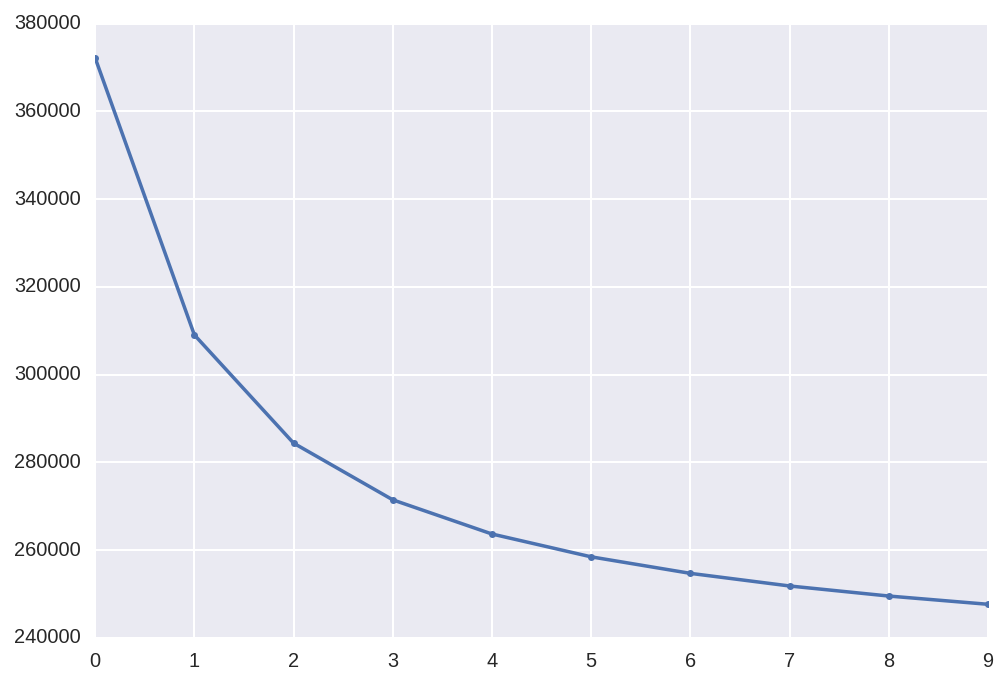

In [352]:
plt.plot(rest.errors, '.-')

In [349]:
rmse(rest, X_test, y_test)

0.94459141873939834

In [353]:
rest.score(X_train, y_train), rest.score(X_test, y_test)

(0.69015363885246162, 0.20588199831357756)

In [354]:
gs = GridSearchCV(ResidualMatrixFactorization(best_lr, 20, 10, 1),
                  {'alpha': [1,3,10,30]})

In [355]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=ResidualMatrixFactorization(alpha=1,
              base_est=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        spa...te=None, solver='auto',
   tol=0.001))]),
              iter_errors=False, n_factors=20, n_iters=10),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 3, 10, 30]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [356]:
gs.best_params_

{'alpha': 30}

In [357]:
rmse(gs, X_test, y_test)

0.83719248836692939

In [358]:
gs = GridSearchCV(ResidualMatrixFactorization(best, 20, 10, 30),
                  {'n_factors': [10, 20, 50, 100]})

In [359]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=ResidualMatrixFactorization(alpha=30,
              base_est=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sp...te=None, solver='auto',
   tol=0.001))]),
              iter_errors=False, n_factors=20, n_iters=10),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_factors': [10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [360]:
gs.best_params_

{'n_factors': 100}

In [361]:
rmse(gs, X_test, y_test)

0.83619206738555119

In [393]:
rest = ResidualMatrixFactorization(best_lr, 20, 1, 10)

In [394]:
%%timeit
rest.fit(X_train, y_train)

1 loop, best of 3: 21.5 s per loop


In [397]:
rmse(rest, X_test, y_test)

0.87693311485564762

##  Exercises

1. Add other user-item interaction models.  Random forest?  Similarity of movie to user's favorites? Blend with linear model.

2. Use GBT to blend models (following Netflix Prize model).

3. Deploy to flask app.  Give framework?